In [ ]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

stats = pd.read_csv("stats.csv")

# MLB Statcast Analysis
Does taking more pitches create better results?
How much does taking a first strike hurt?

In [ ]:
stats.head(5)

,last_name,first_name,player_id,year,b_ab,b_swinging_strike,xba,xslg,xwoba,xobp,...,exit_velocity_avg,launch_angle_avg,sweet_spot_percent,barrel,barrel_batted_rate,z_swing_percent,oz_swing_percent,pitch_count,f_strike_percent,Unnamed: 20
0,Cabrera,Miguel,408234,2021,472,259,0.234,0.420,0.315,0.301,...,91.4,10.0,32.8,30,8.3,69.1,30.3,2035,62.5,NaN
1,Cruz Jr.,Nelson,443558,2021,513,344,0.265,0.514,0.364,0.341,...,92.9,11.8,31.8,54,13.6,73.8,31.0,2198,63.4,NaN
2,Peralta,David,444482,2021,487,204,0.243,0.345,0.293,0.313,...,89.3,5.3,27.2,20,5.0,66.6,27.0,2062,57.8,NaN
3,Blackmon,Charlie,453568,2021,514,205,0.292,0.457,0.361,0.370,...,87.6,10.2,32.6,30,7.0,67.8,26.2,2144,61.3,NaN
4,McCutchen,Andrew,457705,2021,482,249,0.240,0.431,0.344,0.352,...,88.8,14.6,33.6,32,9.0,63.7,19.1,2308,62.1,NaN


Let's take a look at how well batters hit compared to how many pitches they see.

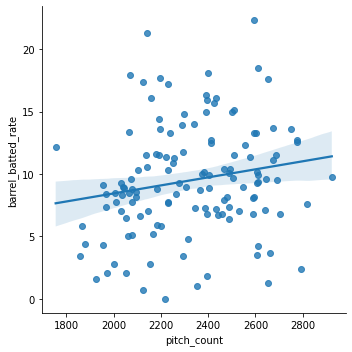

In [ ]:
sns.lmplot(data = stats, x = "pitch_count", y = "barrel_batted_rate")

A "barrel" in these terms is a hit that has an exit velocity of at least 98mph, with a widening allowable launch angle with higher velocities (at lower exit velocities, a hit must be sent at a more optimal launch angle to qualify as a barrel.)

At first glance, it appears that taking more pitches doesn't have much of a correlation with the average barrel rate, seeming to imply that being more patient at the plate doesn't necessarily result in better contact.

However, there are some potential flaws in the data: A batter with more at-bats will almost certainly see more pitches than a batter with less at-bats. Determining how many pitches each batter sees per at bat will potentially give better results.

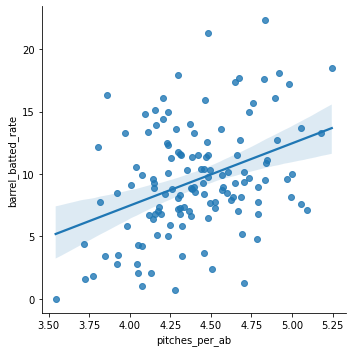

In [ ]:
stats['pitches_per_ab'] = stats['pitch_count'] / stats['b_ab']
sns.lmplot(data = stats, x = "pitches_per_ab", y = "barrel_batted_rate")

It appears that this creates a bit more of a correlation between patience at the plate and getting clean contact on the ball. There are still many outliers, but it certainly seems that there is a benefit to waiting for the correct pitch.

Let's now look at how much harder it is to get a solid hit if you take a first strike:

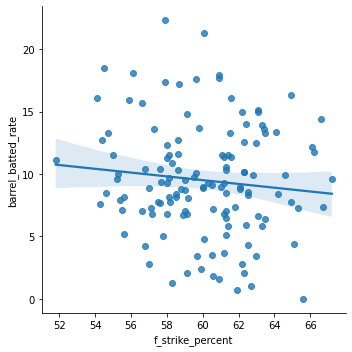

In [ ]:
sns.lmplot(data = stats, x = "f_strike_percent", y = "barrel_batted_rate")

There isn't an extremely strong correlation, but it appears that taking a first-pitch strike definitely affects your ability to get the barrel on the ball. 

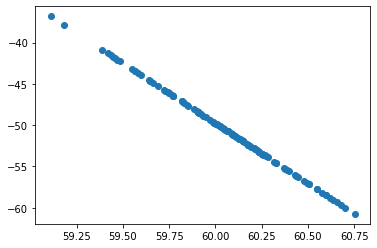

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(stats[['barrel_batted_rate']], stats[['f_strike_percent']])
model_fitted = model.predict(stats[['barrel_batted_rate']])
plt.scatter(model_fitted, stats[['barrel_batted_rate']] - model_fitted)

Running linear regression on the model shows that taking a first-pitch strike makes it far harder to get good contact on a baseball. This makes sense, as a pitcher who already has a 0-1 count can force the batter to chase pitches outside the zone, leading to less solid contact.

Now, let's see if we can find a relationship between swinging at pitches out of the zone and solid contact on hits. In theory, never chasing could lead to less good hits, and always chasing could also lead to worse contact. How much should a batter chase pitches out of the zone?

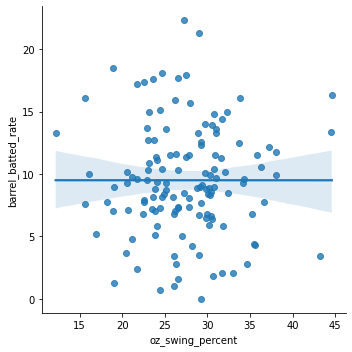

In [10]:
sns.lmplot(data = stats, x = "oz_swing_percent", y = "barrel_batted_rate")

It appears running standard lines of best fit don't really work on this dataset. This makes sense, given our assumptions. Let's try some polynomial features after trying a standard linear regression.

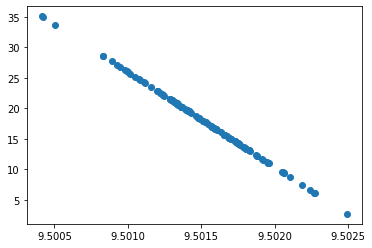

In [11]:
model2 = LinearRegression()
model2.fit(stats[['oz_swing_percent']], stats[['barrel_batted_rate']])
model2_fitted = model2.predict(stats[['oz_swing_percent']])
plt.scatter(model2_fitted, stats[['oz_swing_percent']] - model2_fitted)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  "X does not have valid feature names, but"


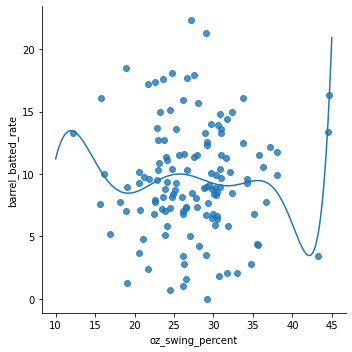

In [33]:
stats["oz_swing_percent_8"] = stats["oz_swing_percent"] ** 8
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(degree=8)
x = transformer.fit_transform(stats[['oz_swing_percent']])
clf = LinearRegression(fit_intercept=False)
clf.fit(x, stats["barrel_batted_rate"])
clf.coef_
sns.lmplot(x='oz_swing_percent', y='barrel_batted_rate', data=stats, fit_reg=False)
xs = np.linspace(10,45,2500).reshape(-1,1)
ys = clf.predict(transformer.transform(xs))
plt.plot(xs,ys)

The results return a very interesting line. It appears that the opposite of my assumptions are true - Swinging out of the zone an average amount seems to have not much bearing on whether or not your contact is good. However, since there's so much less data at the margins, I think there's a chance that a few outliers are potentially corrupting the data.